# Model Evaluations

> This module contains some functions to evaluate your model in-depth

- skip_showdoc: true
- skip_exec: true

In [ ]:
#| default_exp evaluations

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import os

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [ ]:
from that_nlp_library.text_transformation import *
from that_nlp_library.text_augmentation import *
from that_nlp_library.text_main import *
from that_nlp_library.utils import seed_everything

In [ ]:
from underthesea import text_normalize
from functools import partial
from pathlib import Path
from transformers import RobertaTokenizer
from transformers.models.roberta.modeling_roberta import RobertaForSequenceClassification
import nlpaug.augmenter.char as nac
from datasets import load_dataset
import random
import pandas as pd
import numpy as np

In [ ]:
from that_nlp_library.model_main import *
from sklearn.metrics import f1_score, accuracy_score

comet_ml is installed but `COMET_API_KEY` is not set.


## Evaluation for Single-head/Multi-head Classification

### Create a TextDataController

In [ ]:
# Define the custom augmentation function

def nlp_aug_stochastic(x,aug=None,p=0.5):
    if not isinstance(x,list): 
        if random.random()<p: return aug.augment(x)[0]
        return x
    news=[]
    originals=[]
    for _x in x:
        if random.random()<p: news.append(_x)
        else: originals.append(_x)
    # only perform augmentation when needed
    if len(news): news = aug.augment(news)
    return news+originals

In [ ]:
aug = nac.KeyboardAug(aug_char_max=3,aug_char_p=0.1,aug_word_p=0.07)
nearby_aug_func = partial(nlp_aug_stochastic,aug=aug,p=0.3)

In [ ]:
dset = load_dataset('sample_data',data_files=['Womens_Clothing_Reviews.csv'],split='train')

In [ ]:
tdc = TextDataController(dset,
                         main_text='Review Text',
                         label_names='Department Name',
                         sup_types='classification',
                         filter_dict={'Review Text': lambda x: x is not None,
                                      'Department Name': lambda x: x is not None,
                                     },
                         metadatas=['Title','Division Name'],
                         content_transformations=[text_normalize,str.lower],
                         content_augmentations= [nearby_aug_func,str.lower], 
                         # add "str.lower" here because nearby_aug might return uppercase character
                         val_ratio=0.2,
                         batch_size=1000,
                         seed=42,
                         num_proc=20,
                         verbose=False
                        )

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tdc.process_and_tokenize(tokenizer,max_length=100,shuffle_trn=True)

Map (num_proc=20):   0%|          | 0/18102 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/18102 [00:00<?, ? examples/s]

Flattening the indices (num_proc=20):   0%|          | 0/18102 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/18102 [00:00<?, ? examples/s]

Map (num_proc=20):   0%|          | 0/4526 [00:00<?, ? examples/s]

## Define and train model

In [ ]:
num_classes = len(tdc.label_lists[0])
metric_funcs = [partial(f1_score,average='macro'),accuracy_score] 

In [ ]:
seed_everything(42)
model_name='roberta-base'
model = RobertaForSequenceClassification.from_pretrained(model_name,num_labels=num_classes).to('cuda:0')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
controller = ModelController(model,
                             data_store=tdc,
                             seed=42)

In [ ]:
lr = 1e-4
bs=32
wd=0.01
epochs= 3

controller.fit(epochs,lr,
               metric_funcs=metric_funcs,
               batch_size=bs,
               weight_decay=wd,
               save_checkpoint=False,
               compute_metrics=compute_metrics,
              )

/home/quan/anaconda3/envs/fastai_v2/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score Department name,Accuracy Score Department name
1,No log,0.319571,0.742791,0.910959
2,0.419700,0.304928,0.745112,0.917145
3,0.419700,0.271433,0.750710,0.921785


## Generate predictions

We will do model evaluation on the validation set

In [ ]:
df_val = controller.predict_ddict(ds_type='validation')

-------------------- Start making predictions --------------------


Map:   0%|          | 0/4526 [00:00<?, ? examples/s]

Map:   0%|          | 0/4526 [00:00<?, ? examples/s]

In [ ]:
df_val = df_val.to_pandas()
df_val.head()

,Title,Review Text,Division Name,Department Name,label,input_ids,attention_mask,pred_Department Name,pred_prob_Department Name
0,,general petite . . such a fun jacket ! great t...,general petite,Intimate,2,"[0, 15841, 4716, 1459, 479, 479, 215, 10, 1531...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Jackets,0.816035
1,simple and elegant,general petite . simple and elegant . i though...,general petite,Tops,4,"[0, 15841, 4716, 1459, 479, 2007, 8, 14878, 47...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Tops,0.995620
2,retro and pretty,general . retro and pretty . this top has a bi...,general,Tops,4,"[0, 15841, 479, 11299, 8, 1256, 479, 42, 299, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Tops,0.995227
3,summer/fall wear,general petite . summer / fall wear . i first ...,general petite,Dresses,1,"[0, 15841, 4716, 1459, 479, 1035, 1589, 1136, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Dresses,0.981572
4,perfect except slip,general petite . perfect except slip . this is...,general petite,Dresses,1,"[0, 15841, 4716, 1459, 479, 1969, 4682, 9215, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Dresses,0.984236


## Start the model evaluation

In [ ]:
#| export
from __future__ import annotations
from that_nlp_library.utils import *
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#| hide
#| export
def _show_metrics(label,pred,metric_funcs):
    results=''
    for m_func in metric_funcs:
        m_name=callable_name(m_func)
        results+=f'{m_name}: {m_func(label,pred):.4f} . '
    return results

In [ ]:
#| export
def evaluate_classification_model_metadata(df:pd.DataFrame, # The main dataframe containing the predictions
                                           metadatas:str|list, # Metadata(s) to perform analysis
                                           label_name:str, # Label's column name
                                           pred_name:str, # Prediction's column name
                                           metric_funcs:list, # Metric(s) to calculate
                                          ):
    metadatas = val2iterable(metadatas)
    metric_funcs = val2iterable(metric_funcs)
    
    for metadata in metadatas:
        print_msg(f'{label_name} Analysis on metadata: {metadata}',20)
        print_msg('Distribution',10)
        print(pd.concat((df[metadata].value_counts(),df[metadata].value_counts(normalize=True)),axis=1))
        print()
        print_msg(f'Metrics for each value in {metadata}',10)
        print(f'- For all data:\n{_show_metrics(df[label_name].values,df[pred_name].values,metric_funcs)}')
        for val in np.sort(df[metadata].unique()):
            y_true=df.loc[df[metadata]==val,label_name].values
            y_pred=df.loc[df[metadata]==val,pred_name].values
            print(f'- For {val}:\n{_show_metrics(y_true,y_pred,metric_funcs)}')

In [ ]:
show_doc(evaluate_classification_model_metadata)

---

[source](https://github.com/anhquan0412/that-nlp-library/blob/main/that_nlp_library/evaluations.py#L24){target="_blank" style="float:right; font-size:smaller"}

### evaluate_classification_model_metadata

>      evaluate_classification_model_metadata (df:pandas.core.frame.DataFrame,
>                                              metadatas:str|list,
>                                              label_name:str, pred_name:str,
>                                              metric_funcs:list)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| df | pd.DataFrame | The main dataframe containing the predictions |
| metadatas | str \| list | Metadata(s) to perform analysis |
| label_name | str | Label's column name |
| pred_name | str | Prediction's column name |
| metric_funcs | list | Metric(s) to calculate |

In [ ]:
metric_funcs = [partial(f1_score,average='macro'),accuracy_score]

In [ ]:
evaluate_classification_model_metadata(df_val,metadatas='Division Name',
                                       label_name='Department Name',
                                       pred_name='pred_Department Name',
                                       metric_funcs=metric_funcs
                                      )

-------------------- Department Name Analysis on metadata: Division Name --------------------
---------- Distribution ----------
                count  proportion
Division Name                    
general          2688    0.593902
general petite   1546    0.341582
initmates         292    0.064516

---------- Metrics for each value in Division Name ----------
- For all data:
f1_score: 0.7507 . accuracy_score: 0.9218 . 
- For general:
f1_score: 0.5950 . accuracy_score: 0.9189 . 
- For general petite:
f1_score: 0.6108 . accuracy_score: 0.9120 . 
- For initmates:
f1_score: 1.0000 . accuracy_score: 1.0000 . 


In [ ]:
#| export
def show_top_n_predictions(df:pd.DataFrame, # The main dataframe containing the predictions
                          text_name:str, # Text's column name
                          label_name:str, # Label's column name
                          pred_name:str, # Prediction's column name
                          prob_name:str, # Prediction probability's column name
                          is_incorrect=True, # To show top correct or incorrect sentences
                          ascending=False, # To sort by prob_name ascendingly or descendingly
                          n_show=10, # Number of sentences to show
                         ):
    if is_incorrect:
        df = df[df[pred_name]!=df[label_name]]
    else:
        df = df[df[pred_name]==df[label_name]]
    df = df.sort_values(prob_name,ascending=ascending)[[text_name,label_name,pred_name,prob_name]].head(n_show).values
    for row in df:
        print(f'Text: {row[0]}')
        print(f'True label: {row[1]}, {"but" if is_incorrect else ""} predict {row[2]}, with confidence {row[3]:.4f}')
        print('-'*60)

In [ ]:
show_doc(show_top_n_predictions)

---

[source](https://github.com/anhquan0412/that-nlp-library/blob/main/that_nlp_library/evaluations.py#L46){target="_blank" style="float:right; font-size:smaller"}

### show_top_n_predictions

>      show_top_n_predictions (df:pandas.core.frame.DataFrame, text_name:str,
>                              label_name:str, pred_name:str, prob_name:str,
>                              is_incorrect=True, ascending=False, n_show=10)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | pd.DataFrame |  | The main dataframe containing the predictions |
| text_name | str |  | Text's column name |
| label_name | str |  | Label's column name |
| pred_name | str |  | Prediction's column name |
| prob_name | str |  | Prediction probability's column name |
| is_incorrect | bool | True | To show top correct or incorrect sentences |
| ascending | bool | False | To sort by prob_name ascendingly or descendingly |
| n_show | int | 10 | Number of sentences to show |

In [ ]:
show_top_n_predictions(df_val,text_name='Review Text',
                      label_name='Department Name',
                      pred_name='pred_Department Name',
                      prob_name='pred_prob_Department Name',
                      is_incorrect=True,
                      ascending=False,n_show=5)

Text: general . great cozy sweater . i initially bought the red and blue sweater in a medium . i usually wear a large and the medium fits perfectly and is still a bit baggy . i'm tall ( 5 ' 9 " ) and so i love the length of the sleeves when they are unrolled . it's a very versatile piece . with sleeves rolled down you can fold the collar so the red is out of sight and just have a navy blue sweater . either look is nice . i loved it so much i bought the black and brown version . also , the fabric doesn't feel thick but it is very insulating and
True label: Jackets, but predict Tops, with confidence 0.9958
------------------------------------------------------------
Text: general . is this top orange or red . wish this site had " ask a question about the product " feature like amazon does . just wondering if anyone has seen this product in person to verify color ? it looks orange but descriptor says red . would appreciate feedback . thank you for your help .
True label: Jackets, but pred

In [ ]:
show_top_n_predictions(df_val,text_name='Review Text',
                      label_name='Department Name',
                      pred_name='pred_Department Name',
                      prob_name='pred_prob_Department Name',
                      is_incorrect=True,
                      ascending=True,n_show=5)

Text: general . super cute , poor quality . i wore this for the first time today , and after just about an hour , it gently nicked something and got a hole in the pack . its so disappointing as i love they style and its so comfortable . very poor quality for the price : (
True label: Dresses, but predict Tops, with confidence 0.3295
------------------------------------------------------------
Text: general petite . great feel . order a size down
True label: Dresses, but predict Tops, with confidence 0.3326
------------------------------------------------------------
Text: general . cute and comfy . very cute and true to size if not just a little large up top .
True label: Bottoms, but predict Intimate, with confidence 0.3363
------------------------------------------------------------
Text: general petite . pretty design but poor quality . pretty design , but when i tried it on , the fabric was thin and delicate . i don't think it would last long with much wear . too bad . if the fabri

In [ ]:
#| export
def evaluate_classification_model(df:pd.DataFrame, # The main dataframe containing the predictions
                              text_name:str, # Text's column name
                              label_name:str, # Label's column name
                              pred_name:str, # Prediction's column name
                              prob_name:str, # Prediction probability's column name
                              metric_funcs:list=[], # Metric(s) to calculate
                              metadatas:str|list=[], # Metadata(s) to perform analysis
                              n_show=10, # Number of sentences to show
                              cm_figsize=(20,20), # Confusion matrix's figure size
                             ):

    y_true = df[label_name].values
    y_pred = df[pred_name].values
    print_msg(f'{label_name} Analysis',20)
    print()
    print_msg('Classification Report',15)
    print(classification_report(y_true,y_pred))
    print()
    print_msg('Confusion Matrix',15)
    fig,ax = plt.subplots(figsize=cm_figsize)
    ConfusionMatrixDisplay.from_predictions(y_true,y_pred,xticks_rotation='vertical',ax=ax)
    plt.show()
    print()
    evaluate_classification_model_metadata(df,metadatas,label_name,pred_name,metric_funcs)
    print()
    print_msg("Let's look at some wrong predictions with high confidence",15)
    show_top_n_predictions(df,text_name,label_name,pred_name,prob_name,
                           is_incorrect=True,
                           ascending=False,
                           n_show=n_show)

In [ ]:
show_doc(evaluate_classification_model)

---

[source](https://github.com/anhquan0412/that-nlp-library/blob/main/that_nlp_library/evaluations.py#L66){target="_blank" style="float:right; font-size:smaller"}

### evaluate_classification_model

>      evaluate_classification_model (df:pandas.core.frame.DataFrame,
>                                     text_name:str, label_name:str,
>                                     pred_name:str, prob_name:str,
>                                     metric_funcs:list=[],
>                                     metadatas:str|list=[], n_show=10,
>                                     cm_figsize=(20, 20))

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | pd.DataFrame |  | The main dataframe containing the predictions |
| text_name | str |  | Text's column name |
| label_name | str |  | Label's column name |
| pred_name | str |  | Prediction's column name |
| prob_name | str |  | Prediction probability's column name |
| metric_funcs | list | [] | Metric(s) to calculate |
| metadatas | str \| list | [] | Metadata(s) to perform analysis |
| n_show | int | 10 | Number of sentences to show |
| cm_figsize | tuple | (20, 20) | Confusion matrix's figure size |

-------------------- Department Name Analysis --------------------

--------------- Classification Report ---------------
              precision    recall  f1-score   support

     Bottoms       0.93      0.92      0.93       695
     Dresses       0.93      0.92      0.93      1248
    Intimate       0.98      0.86      0.91       341
     Jackets       0.79      0.81      0.80       213
        Tops       0.92      0.95      0.94      2010
       Trend       0.00      0.00      0.00        19

    accuracy                           0.92      4526
   macro avg       0.76      0.74      0.75      4526
weighted avg       0.92      0.92      0.92      4526


--------------- Confusion Matrix ---------------


/home/quan/anaconda3/envs/fastai_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/quan/anaconda3/envs/fastai_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/quan/anaconda3/envs/fastai_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

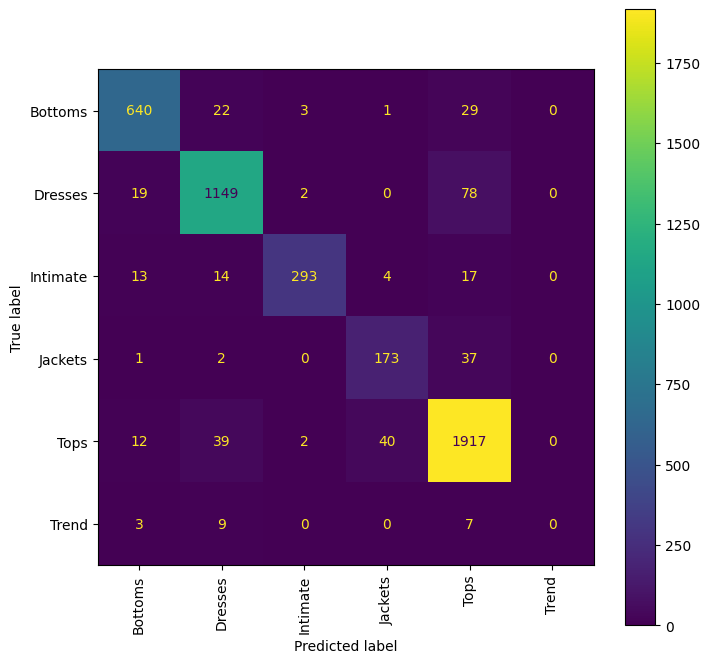


-------------------- Department Name Analysis on metadata: Division Name --------------------
---------- Distribution ----------
                count  proportion
Division Name                    
general          2688    0.593902
general petite   1546    0.341582
initmates         292    0.064516

---------- Metrics for each value in Division Name ----------
- For all data:
f1_score: 0.7507 . accuracy_score: 0.9218 . 
- For general:
f1_score: 0.5950 . accuracy_score: 0.9189 . 
- For general petite:
f1_score: 0.6108 . accuracy_score: 0.9120 . 
- For initmates:
f1_score: 1.0000 . accuracy_score: 1.0000 . 

--------------- Let's look at some wrong predictions with high confidence ---------------
Text: general . great cozy sweater . i initially bought the red and blue sweater in a medium . i usually wear a large and the medium fits perfectly and is still a bit baggy . i'm tall ( 5 ' 9 " ) and so i love the length of the sleeves when they are unrolled . it's a very versatile piece . with 

In [ ]:
evaluate_classification_model(df_val,text_name='Review Text',
                              label_name='Department Name',
                              pred_name='pred_Department Name',
                              prob_name='pred_prob_Department Name',
                              metric_funcs=metric_funcs,
                              metadatas='Division Name',
                              cm_figsize=(8,8),
                              n_show=5
                             )

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()